In [1]:
import numpy as np
import matplotlib.pyplot as plt
from util import *
from synth_spec import *

First, get observed spectrum (flattened and merged).

In [3]:
KPF_file = "../../KP.20240619.75381.18_L1.fits"
stitched_wave, stitched_flux, wave_1D, flux_1D = merge_spec(KPF_file, color="GREEN")

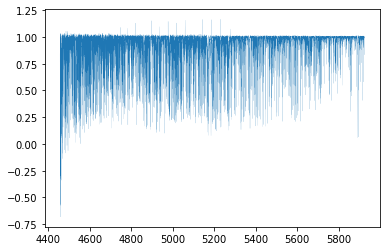

In [4]:
plt.plot(wave_1D, flux_1D, lw=0.1)

In [10]:
line_mask = np.loadtxt("../../masks/G2.espresso.mas").T
line_mask_mask = (line_mask[0] > 4500) & (line_mask[0] < 5850)
new_line_mask = line_mask[0][line_mask_mask]
new_line_weight = line_mask[1][line_mask_mask]

In [19]:
velocity_loop = np.arange(-50, 50, 1.0) # velocities to calculate CCF at
v_steps = len(velocity_loop)
LIGHT_SPEED = 3e5
LIGHT_SPEED_M = 3e8
vb = -82e3
zb = vb/LIGHT_SPEED_M
z_b = ((1.0/(1+zb)) - 1.0)

new_line_start = new_line_mask - 0.025
new_line_end = new_line_mask + 0.025

x_pixel_wave = wave_1D
spectrum = flux_1D[1:]

sn = np.ones(len(spectrum))
# sn = my_flux[1:]

In [20]:
def calc_ccf(v_steps, new_line_start, new_line_end, x_pixel_wave, spectrum, new_line_weight, sn, zb=0):
        """ Cross correlation by the shifted mask line and the spectrum data of one order for each velocity step.

        Args:
            v_steps (int): Total velocity steps.
            new_line_start (numpy.ndarray): Start of the mask line.
            new_line_end (numpy.ndarray): End of the mask line.
            x_pixel_wave (numpy.ndarray): Wavelength calibration of the pixels.
            spectrum (numpy.ndarray): 1D Spectrum data.
            new_line_weight (numpy.ndarray): Mask weight
            sn (numpy.ndarray): Additional SNR scaling factor (comply with the implementation of CCF of C version)
            zb (float): Redshift at the observation time.

        Returns:
            numpy.ndarray: ccf at velocity steps.
            numpy.ndarray: Intermediate CCF numbers at pixels.
        """

        ccf = np.zeros(v_steps)
        shift_lines_by = (1.0 + (velocity_loop / LIGHT_SPEED)) / (1.0 + zb)

        n_pixel = np.shape(x_pixel_wave)[0] - 1                # total size in  x_pixel_wave_start
        n_line_index = np.shape(new_line_start)[0]

        pix1, pix2 = 0, n_pixel-1
        x_pixel_wave_end = x_pixel_wave[1: n_pixel+1]            # total size: n_pixel
        x_pixel_wave_start = x_pixel_wave[0: n_pixel]
        ccf_pixels = np.zeros([v_steps, n_pixel])

        for c in range(v_steps):
            
            print(c/v_steps)
        
            line_doppler_shifted_start = new_line_start * shift_lines_by[c]
            line_doppler_shifted_end = new_line_end * shift_lines_by[c]

            closest_match = np.sum((x_pixel_wave_end - line_doppler_shifted_start[:, np.newaxis] < 0.), axis=1)
            closest_match_next = np.sum((x_pixel_wave_start - line_doppler_shifted_end[:, np.newaxis] <= 0.), axis=1)
            mask_spectra_doppler_shifted = np.zeros(n_pixel)

            idx_collection = list()
            for k in range(n_line_index):
                closest_x_pixel = closest_match[k]  # closest index starting before line_dopplershifted_start
                closest_x_pixel_next = closest_match_next[k]  # closest index starting after line_dopplershifted_end
                line_start_wave = line_doppler_shifted_start[k]
                line_end_wave = line_doppler_shifted_end[k]
                line_weight = new_line_weight[k]

                if closest_x_pixel_next <= pix1 or closest_x_pixel >= pix2:
                    continue
                else:
                    for n in range(closest_x_pixel, closest_x_pixel_next):
                        if n > pix2:
                            break
                        if n < pix1:
                            continue
                        # if there is overlap
                        if x_pixel_wave_start[n] <= line_end_wave and x_pixel_wave_end[n] >= line_start_wave:
                            wave_start = max(x_pixel_wave_start[n], line_start_wave)
                            wave_end = min(x_pixel_wave_end[n], line_end_wave)
                            mask_spectra_doppler_shifted[n] = line_weight * (wave_end - wave_start) / \
                                (x_pixel_wave_end[n] - x_pixel_wave_start[n])

                            if n in idx_collection:
                                pass
                                # print(str(n), ' already taken')
                            else:
                                idx_collection.append(n)
            ccf_pixels[c, :] = spectrum * mask_spectra_doppler_shifted * sn
            ccf[c] = np.nansum(ccf_pixels[c, :])
        return ccf, ccf_pixels

In [21]:
test = calc_ccf(v_steps, new_line_start, new_line_end, x_pixel_wave, spectrum, new_line_weight, sn, -z_b)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


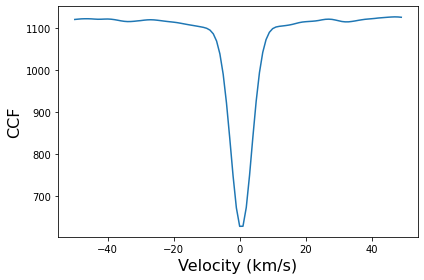

In [22]:
mask_vel = np.ones(len(test[0]), dtype=bool)
plt.plot(velocity_loop[mask_vel], test[0][mask_vel])
plt.ylabel("CCF", fontsize=16)
plt.xlabel("Velocity (km/s)", fontsize=16)
# plt.xlim()
plt.tight_layout()

In [27]:
my_ccf = ((-test[0][mask_vel]) + np.max(test[0][mask_vel])) / np.max(((-test[0][mask_vel]) + np.max(test[0][mask_vel])))
my_vel = velocity_loop[mask_vel]

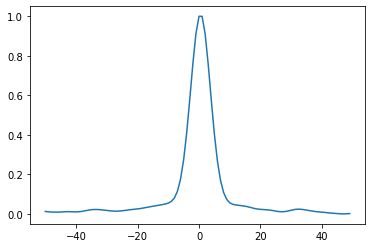

In [28]:
plt.plot(my_vel, my_ccf);

Test scipy find_peaks function to determine optimal parameters.

In [24]:
from scipy.signal import find_peaks

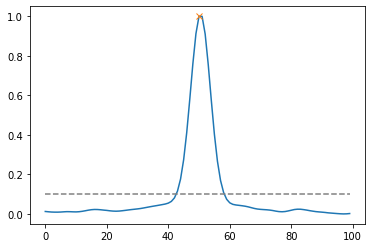

In [34]:
peaks, _ = find_peaks(my_ccf, height=0.1)
plt.plot(my_ccf)
plt.plot(peaks, my_ccf[peaks], "x")
plt.plot(np.full_like(my_ccf, 0.1), "--", color="gray")
plt.show()

Add a synthetic spectrum with a redshift.

In [35]:
filename = "synth_spec.hdf5"
Teff_target = 5800
Z_target = 0

download_stellar_model_grid(filename, Teff_target, Z_target)

lte05800-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [07:50<00:00,  6.53s/it]
Processing [5.8e+03 5.0e+00 0.0e+00]: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:50<00:00,  1.42it/s]


In [39]:
synth_wave, synth_flux = get_synth_spectrum(filename, 4500, 4.5, 0)

synth_mask = (synth_wave > 4500) & (synth_wave < 5850)

_, _, _, flat_synth_flux, yfit = flatspec_spline(synth_wave[synth_mask], synth_flux[synth_mask], np.ones(len(synth_wave[synth_mask])))

combined_wave, combined_flux = combine_spectra(synth_wave[synth_mask], flat_synth_flux, wave_1D, flux_1D, rv=-25+82, a=0.5, vsini=2)


keeping grid as is


In [40]:
test = calc_ccf(v_steps, new_line_start, new_line_end, combined_wave, combined_flux[1:], new_line_weight, sn, -z_b)

0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24
0.25
0.26
0.27
0.28
0.29
0.3
0.31
0.32
0.33
0.34
0.35
0.36
0.37
0.38
0.39
0.4
0.41
0.42
0.43
0.44
0.45
0.46
0.47
0.48
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.57
0.58
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.69
0.7
0.71
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.82
0.83
0.84
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.94
0.95
0.96
0.97
0.98
0.99


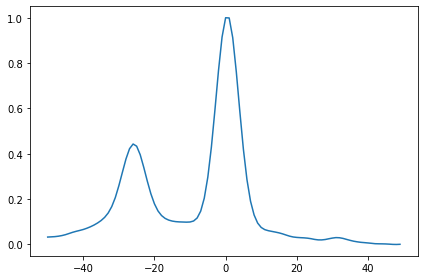

In [41]:
my_ccf = ((-test[0][mask_vel]) + np.max(test[0][mask_vel])) / np.max(((-test[0][mask_vel]) + np.max(test[0][mask_vel])))
my_vel = velocity_loop[mask_vel]

plt.plot(my_vel, my_ccf)
plt.tight_layout()
plt.show()

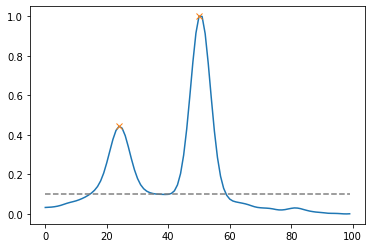

In [42]:
peaks, _ = find_peaks(my_ccf, height=0.1)
plt.plot(my_ccf)
plt.plot(peaks, my_ccf[peaks], "x")
plt.plot(np.full_like(my_ccf, 0.1), "--", color="gray")
plt.show()